In [81]:
# Import general libraries
import cv2
import numpy as np

In [82]:
# Load the image data: loaded as a 2D numpy array
# dtype='>f4': 32 bit little-endian single-precision float
from astropy.io import fits

img_path = 'dataset/hst_skycell-p0047x09y19_acs_wfc_f658n_all_drc.fits'
raw_img = fits.getdata(img_path)
raw_img

array([[0.06443594, 0.06841434, 0.07139368, ..., 0.02888754, 0.03237037,
        0.02642691],
       [0.06885263, 0.06855819, 0.06562158, ..., 0.0266915 , 0.03263195,
        0.02687687],
       [0.07671235, 0.06736119, 0.06497212, ..., 0.02494908, 0.02789946,
        0.02291822],
       ...,
       [0.        , 0.        , 0.        , ..., 0.10136244, 0.09310704,
        0.08513456],
       [0.        , 0.        , 0.        , ..., 0.09383222, 0.09267957,
        0.08422165],
       [0.        , 0.        , 0.        , ..., 0.08960038, 0.09087212,
        0.08811679]], shape=(4940, 4940), dtype='>f4')

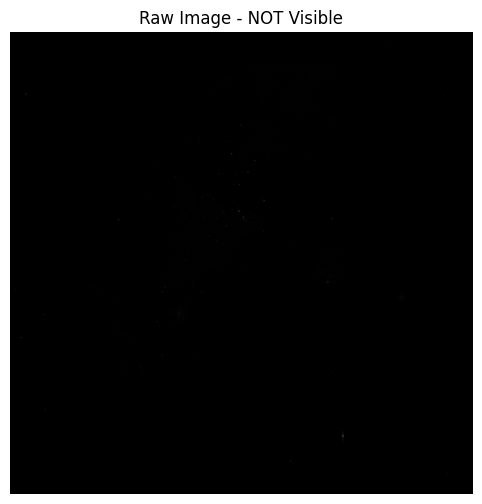

In [83]:
# Simple image plot
# Just to show that a transormation is needed to display the image
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
plt.imshow(raw_img, cmap='gray')
plt.title('Raw Image - NOT Visible')
plt.axis('off')
plt.show()

In [84]:
# Using auto_stretch library to visualize the image
from auto_stretch import apply_stretch

stretched_img = apply_stretch(raw_img)
stretched_img

array([[0.10033418, 0.11190283, 0.12037408, ..., 0.        , 0.        ,
        0.        ],
       [0.1131592 , 0.1123156 , 0.10381313, ..., 0.        , 0.        ,
        0.        ],
       [0.13510314, 0.10886937, 0.1019108 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.19741017, 0.17756398,
        0.1574474 ],
       [0.        , 0.        , 0.        , ..., 0.17934641, 0.17650966,
        0.1550812 ],
       [0.        , 0.        , 0.        , ..., 0.16883495, 0.17202188,
        0.16508605]], shape=(4940, 4940), dtype=float32)

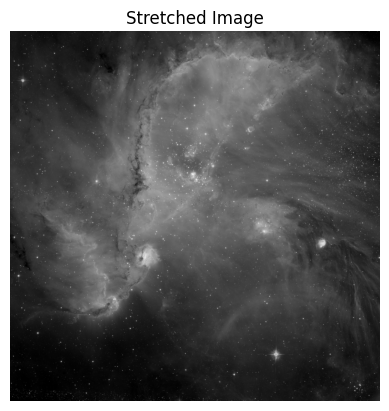

In [85]:
# Plot stretched image
plt.imshow(stretched_img, cmap='gray')
plt.title('Stretched Image')
plt.axis('off')
plt.show()

In [86]:
from math import ceil

# Define Gaussian Kernel
# FWHM: full width at half maximum, a measure to estimate the size of stars
# compute the kernel for small/medium size stars, as bigger ones are fewer and can be treated separately
FHWM = 7 # pixels
sigma = ceil(FHWM / 2.355) # std deviation
kernel_size = (6*sigma) + 1 # rule for kernel size

print(f'Sigma: {sigma}')
print(f'Kernel size: {kernel_size}x{kernel_size}')

Sigma: 3
Kernel size: 19x19


In [87]:
gauss_img = cv2.GaussianBlur(stretched_img, (kernel_size, kernel_size), sigma)
gauss_img

array([[1.09471083e-01, 1.09259412e-01, 1.08642317e-01, ...,
        8.19939232e-05, 7.83500072e-05, 7.77719397e-05],
       [1.09538093e-01, 1.09326296e-01, 1.08707674e-01, ...,
        9.37950172e-05, 9.03043838e-05, 8.98599610e-05],
       [1.09717764e-01, 1.09507129e-01, 1.08888626e-01, ...,
        1.27341424e-04, 1.24148966e-04, 1.24029073e-04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.70138717e-01, 1.70578241e-01, 1.70721337e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.70296177e-01, 1.70806482e-01, 1.70972943e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.70349181e-01, 1.70884788e-01, 1.71059623e-01]],
      shape=(4940, 4940), dtype=float32)

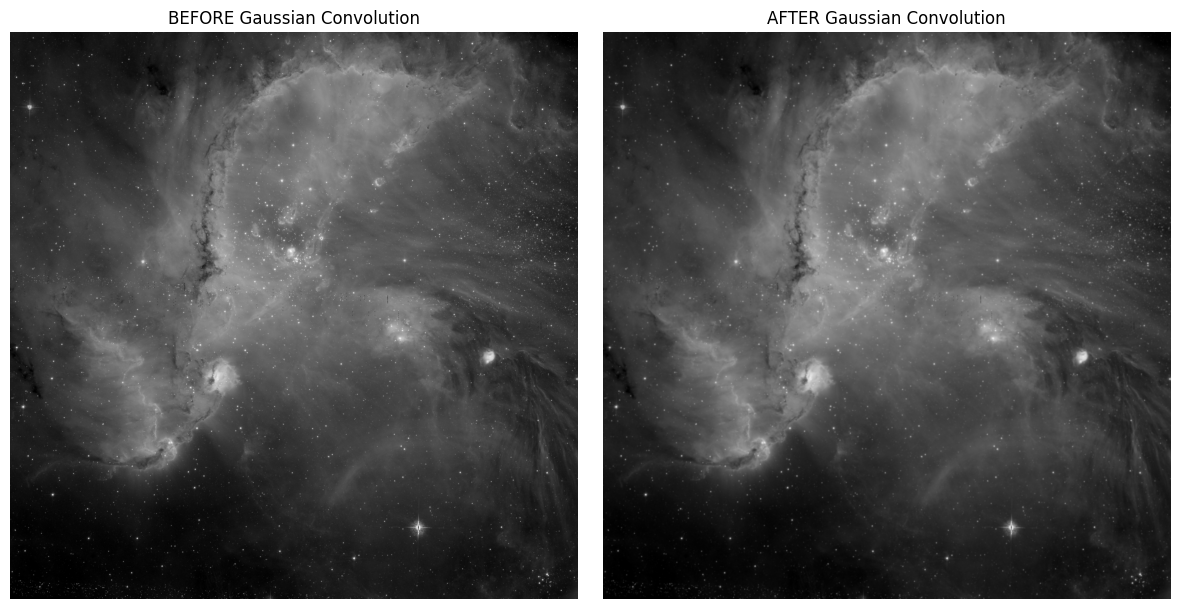

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot image BEFORE convolution against Gaussian kernel
axes[0].imshow(stretched_img, cmap='gray')
axes[0].set_title('BEFORE Gaussian Convolution')
axes[0].axis('off')

# Plot image AFTER convolution against Gaussian kernel
axes[1].imshow(gauss_img, cmap='gray')
axes[1].set_title('AFTER Gaussian Convolution')
axes[1].axis('off')

plt.tight_layout()
plt.show()

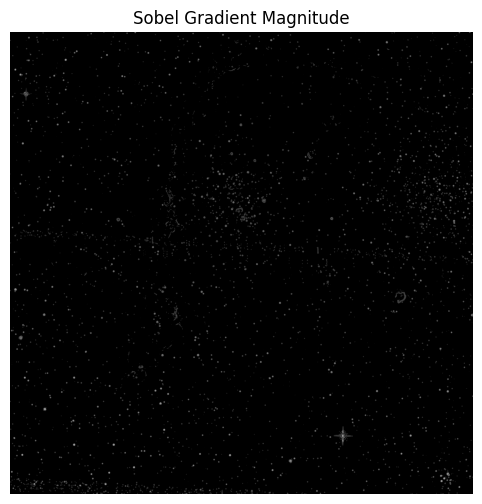

In [60]:
# Sobel gradient
sobel_x = cv2.Sobel(gauss_img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gauss_img, cv2.CV_64F, 0, 1, ksize=3)
grad_mag = cv2.magnitude(sobel_x, sobel_y)
grad_mag = cv2.convertScaleAbs(grad_mag, alpha=5.0)

# Display the gradient magnitude
plt.figure(figsize=(12,6))
plt.imshow(grad_mag, cmap='gray')
plt.title('Sobel Gradient Magnitude')
plt.axis('off')
plt.show()


In [61]:
# Apply thresholding to the gradient magnitude
# Simple binary thresholding
T = 1e-4  # threshold
max_intensity = 1
_, binary_mask = cv2.threshold(grad_mag, T, max_intensity, cv2.THRESH_BINARY)


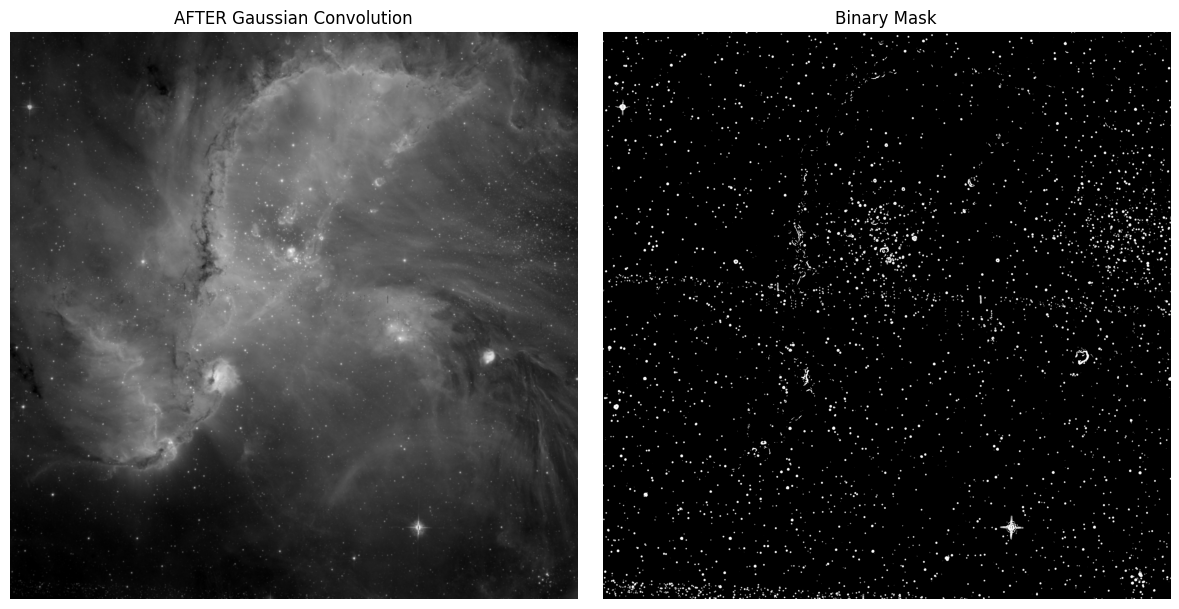

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Gaussian convolved image
axes[0].imshow(gauss_img, cmap='gray')
axes[0].set_title('AFTER Gaussian Convolution')
axes[0].axis('off')

# Plot the binary mask
axes[1].imshow(binary_mask, cmap='gray')
axes[1].set_title('Binary Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [88]:
# Using morphological closing to close small gaps in edges before filling
def morph_close_and_fill(mask):
    # Create a kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    # Close small gaps in the edges
    closed_edges = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Find contours and fill
    contours, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_mask = np.zeros_like(mask)
    cv2.drawContours(filled_mask, contours, -1, 255, -1)
    
    return filled_mask

final_mask = morph_close_and_fill(binary_mask)

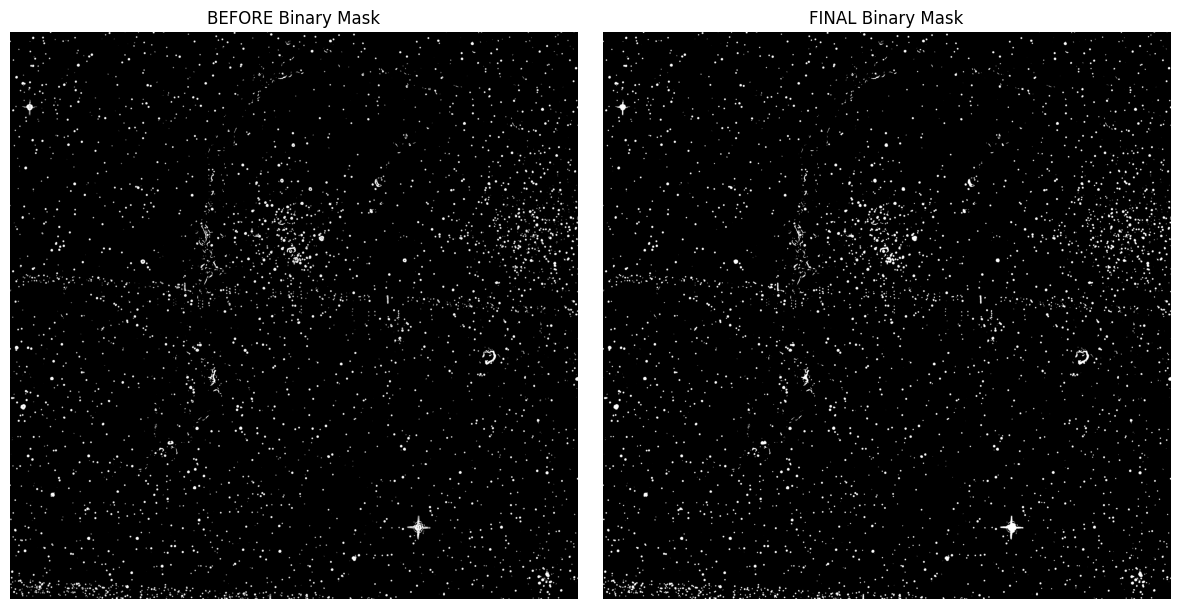

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot BEFORE binary mask
axes[0].imshow(binary_mask, cmap='gray')
axes[0].set_title('BEFORE Binary Mask')
axes[0].axis('off')

# Plot FINAL binary mask
axes[1].imshow(final_mask, cmap='gray')
axes[1].set_title('FINAL Binary Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [65]:
def float32_to_uint8(float_img):
    """
    Convert a float32 image to uint8 format.
    
    Parameters:
    - float_img: np.float32 array, input image
    
    Returns:
    - np.uint8 array, output image with values in range 0-255
    """
    # Check the current range of the image
    min_val = float_img.min()
    max_val = float_img.max()
    
    # Method 1: Simple scaling (for images already in 0-1 range)
    if 0 <= min_val and max_val <= 1:
        uint8_img = (float_img * 255).astype(np.uint8)
    
    # Method 2: Full normalization (for images with arbitrary ranges)
    else:
        # Normalize to 0-1 range first
        normalized_img = (float_img - min_val) / (max_val - min_val)
        # Then scale to 0-255
        uint8_img = (normalized_img * 255).astype(np.uint8)
    
    return uint8_img

gauss_img_final = float32_to_uint8(gauss_img)

In [66]:
# Perform inpainting for star removal
# INPAINT_TELEA is typically better for small regions like stars
# what is INPAINT_TELEA?

# gauss_img type: ?
# final_mask type: 0-255 uint8 image

inpainted_img = cv2.inpaint(gauss_img_final, final_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

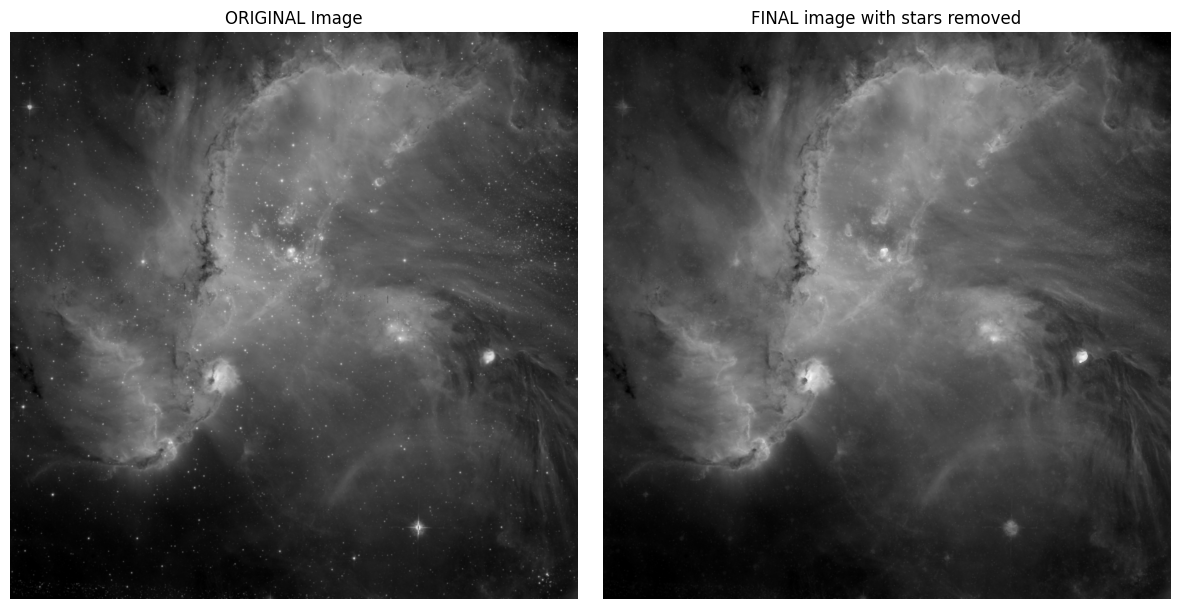

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot ORIGINAL image
axes[0].imshow(gauss_img_final, cmap='gray')
axes[0].set_title('ORIGINAL Image')
axes[0].axis('off')

# Plot FINAL image with stars removed
axes[1].imshow(inpainted_img, cmap='gray')
axes[1].set_title('FINAL image with stars removed')
axes[1].axis('off')

plt.tight_layout()
plt.show()